In [1]:
original_sids = sorted(['KCAT', 'WSFT', 'WW2T', 'TS6T', 'FMFT', 'HCBT', 'PF5T', 'LV2T', 'UM2T', 'MRCT', 'RSIT', 'KP6T', 'NM3T', 'BI3T', 'SC1T', 'SPGT', 'ZK4T', 'GAIT', 'DA9T', 'VL1T'])
len(original_sids)

bias_sids = ['PF5T', 'WW2T', 'WSFT', 'KP6T', 'LV2T', 'FMFT', 'HCBT', 'RSIT', 'TS6T', 'UM2T', 'MRCT', 'NM3T', 'SPGT', 'ZK4T', 'GAIT', 'DA9T', 'VL1T', 'BI3T', 'KCAT']
len(np.unique(bias_sids))

19

In [2]:
def get_convert_matrix(subject_id):
    original_sids = sorted(['KCAT', 'WSFT', 'WW2T', 'TS6T', 'FMFT', 'HCBT', 'PF5T', 'LV2T', 'UM2T', 'MRCT', 'RSIT', 'KP6T', 'NM3T', 'BI3T', 'SC1T', 'SPGT', 'ZK4T', 'GAIT', 'DA9T', 'VL1T'])
    len(original_sids)
    idx = original_sids.index(subject_id)
    return '/home/gdholla1/data/ERC_FLASH_template_ants/composite_transform_5_iterations/_register_5{idx}/transformComposite.h5'.format(idx=idx)

In [3]:
import nipype.pipeline.engine as pe
from nipype.interfaces import utility as util
from nipype.interfaces import ants
from nipype.interfaces import io as nio

In [7]:
workflow = pe.Workflow(name='make_flash_masks', base_dir='/home/gdholla1/workflow_folders/')

identity = pe.Node(util.IdentityInterface(fields=['subject_id']), name='identity')

identity.iterables = [('subject_id', bias_sids)]

templates = {'mask':'/home/gdholla1/data/stop3/masks/original_space/conjunct_masks_2std/{subject_id}_{mask}.nii.gz'}
selector = pe.Node(nio.SelectFiles(templates), name='selector')
selector.iterables = [('mask', ['STh_L', 'STh_R'])]

get_matrix = pe.Node(util.Function(input_names=['subject_id'], output_names=['transformation'], function=get_convert_matrix),
                     name='get_matrix')

apply_transform = pe.Node(ants.ApplyTransforms(), name='apply_transform')
apply_transform.inputs.reference_image = '/home/gdholla1/data/ERC_FLASH_template_ants/template_5_iterations/transform_Warped_merged_mean.nii.gz'
apply_transform.inputs.interpolation = 'NearestNeighbor'

workflow.connect(identity, 'subject_id', selector, 'subject_id')
workflow.connect(identity, 'subject_id', get_matrix, 'subject_id')

workflow.connect(selector, 'mask', apply_transform, 'input_image')
workflow.connect(get_matrix, 'transformation', apply_transform, 'transforms')

ds = pe.Node(nio.DataSink(), name='datasink')
ds.inputs.base_directory = '/home/gdholla1/projects/bias/data/FLASH_group_space/'

workflow.connect(apply_transform, 'output_image', ds, 'individual_masks_in_group_space')

workflow.run()

# Do PCA

In [103]:
import nibabel as nb
threshold = 0.9 * len(masks)


## Left STN

In [104]:
fns = ['/home/gdholla1/projects/bias/data/FLASH_group_space/individual_masks_in_group_space/_subject_id_{}/_mask_STh_L/{}_STh_L_trans.nii.gz'.format(subject_id, subject_id) for subject_id in bias_sids]

In [105]:
images = [nb.load(fn) for fn in fns]
masks = [image.get_data() for image in images]

In [106]:
summed_masks =  np.sum(masks, 0)
x, y, z = np.where((summed_masks > threshold))

import pandas
coords = pandas.DataFrame({'x':x, 'y':y, 'z':z})
coords -= coords.mean()

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(coords)

# Make sure it goes inferior
if pca.components_[0, -1] > 0:
    pca.components_ *= -1

left_stn_pca = pca.components_


transformed_coordinates = pca.transform(np.array(np.where(np.ones_like(summed_masks))).T)
new_data = transformed_coordinates.ravel() + transformed_coordinates.min() + 1
new_data = new_data.reshape(summed_masks.shape)

nb.save(nb.Nifti1Image(new_data, images[0].affine), '/home/gdholla1/projects/bias/data/FLASH_group_space/stn_l_pca.nii.gz')
nb.save(nb.Nifti1Image(summed_masks, images[0].affine), '/home/gdholla1/projects/bias/data/FLASH_group_space/group_stn_l.nii.gz')

# Right STN

In [107]:
fns = ['/home/gdholla1/projects/bias/data/FLASH_group_space/individual_masks_in_group_space/_subject_id_{}/_mask_STh_R/{}_STh_R_trans.nii.gz'.format(subject_id, subject_id) for subject_id in bias_sids]

In [108]:
images = [nb.load(fn) for fn in fns]
masks = [image.get_data() for image in images]

In [109]:
summed_masks =  np.sum(masks, 0)
x, y, z = np.where((summed_masks > threshold))

import pandas
coords = pandas.DataFrame({'x':x, 'y':y, 'z':z})
coords -= coords.mean()

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(coords)

# Make sure it goes inferior
if pca.components_[0, -1] > 0:
    pca.components_ *= -1

right_stn_pca = pca.components_




transformed_coordinates = pca.transform(np.array(np.where(np.ones_like(summed_masks))).T)
new_data = transformed_coordinates.ravel() + transformed_coordinates.min() + 1
new_data = new_data.reshape(summed_masks.shape)

nb.save(nb.Nifti1Image(new_data, images[0].affine), '/home/gdholla1/projects/bias/data/FLASH_group_space/stn_r_pca.nii.gz')
nb.save(nb.Nifti1Image(summed_masks, images[0].affine), '/home/gdholla1/projects/bias/data/FLASH_group_space/group_stn_r.nii.gz')

# Visualize PCA

In [110]:
group_image = nb.load('/home/gdholla1/data/ERC_FLASH_template_ants/template_5_iterations/transform_Warped_merged_mean.nii.gz').get_data()

left_stn = nb.load('/home/gdholla1/projects/bias/data/FLASH_group_space/group_stn_l.nii.gz').get_data()
right_stn = nb.load('/home/gdholla1/projects/bias/data/FLASH_group_space/group_stn_r.nii.gz').get_data()

pca_map_stn_l = nb.load('/home/gdholla1/projects/bias/data/FLASH_group_space/stn_l_pca.nii.gz').get_data()
pca_map_stn_r = nb.load('/home/gdholla1/projects/bias/data/FLASH_group_space/stn_r_pca.nii.gz').get_data()


In [111]:
com_l = ndimage.center_of_mass(left_stn)

In [112]:
com_l

(132.84671884406984, 176.98892233594219, 61.57664057796508)

(170, 190)

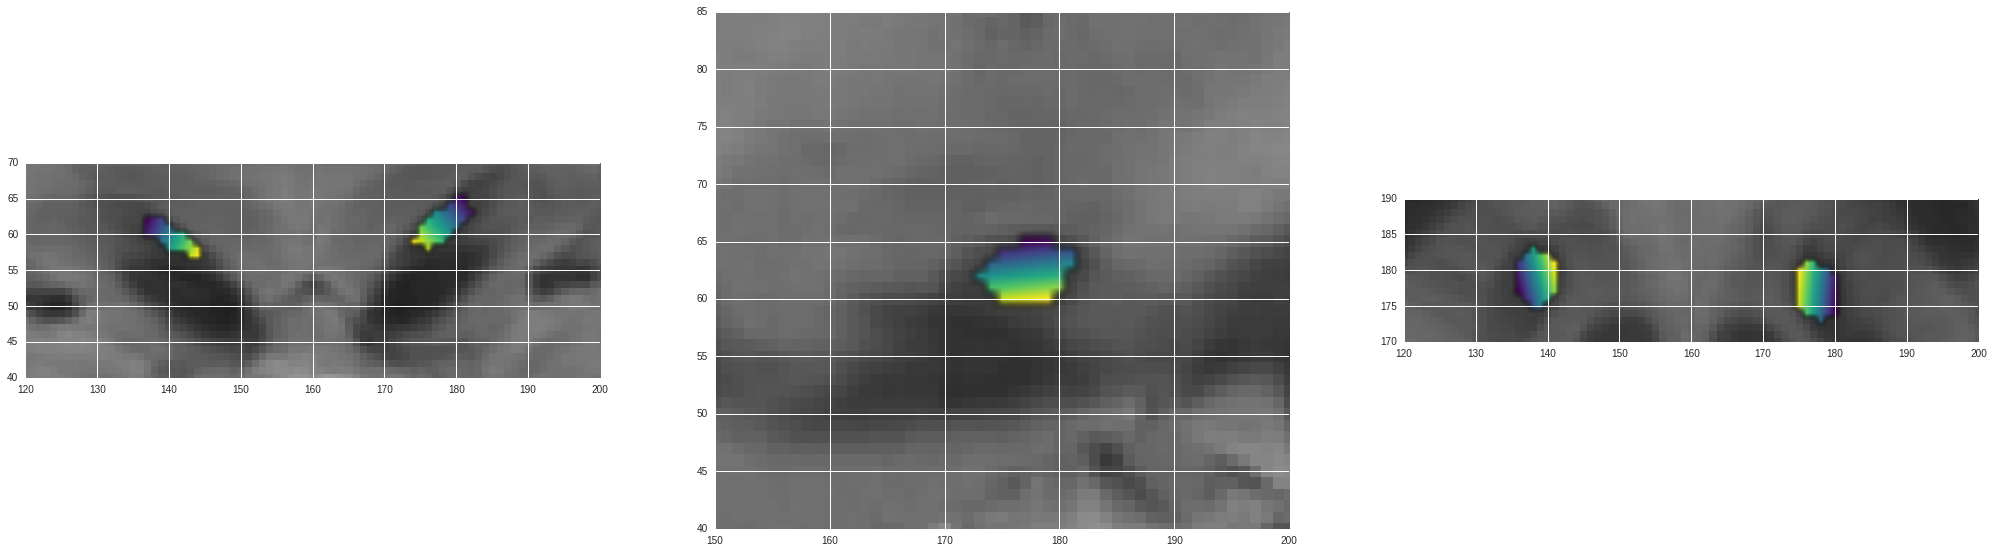

In [116]:
##### pca_map_stn_l_masked = pca_map_stn_l.copy()
pca_map_stn_l_masked[left_stn < 14] = 0
pca_map_stn_l_masked = np.ma.masked_equal(pca_map_stn_l_masked, 0)

pca_map_stn_r_masked = pca_map_stn_r.copy()
pca_map_stn_r_masked[right_stn < 14] = 0
pca_map_stn_r_masked = np.ma.masked_equal(pca_map_stn_r_masked, 0)


plt.figure(figsize=(35, 10))
plt.subplot(131)
plt.imshow(group_image[::-1, 176, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.imshow(pca_map_stn_l_masked[::-1, 176, :].T, origin='lower', cmap=plt.cm.viridis)
plt.imshow(pca_map_stn_r_masked[::-1, 176, :].T, origin='lower', cmap=plt.cm.viridis)
plt.xlim(120, 200)
plt.ylim(40, 70)

plt.subplot(132)
plt.imshow(group_image[132, :, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.imshow(pca_map_stn_l_masked[132, :, :].T, origin='lower', cmap=plt.cm.viridis)
plt.imshow(pca_map_stn_r_masked[132, :, :].T, origin='lower', cmap=plt.cm.viridis)
plt.xlim(150, 200)
plt.ylim(40, 85)


plt.subplot(133)
plt.imshow(group_image[::-1, :, 61].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.imshow(pca_map_stn_l_masked[::-1, :, 61].T, origin='lower', cmap=plt.cm.viridis)
plt.imshow(pca_map_stn_r_masked[::-1, :, 61].T, origin='lower', cmap=plt.cm.viridis)
plt.xlim(120, 200)
plt.ylim(170, 190)

In [117]:
from nipype.interfaces import fsl

In [119]:
applier = fsl.ApplyXfm()
applier.inputs.in_file = '/home/gdholla1/data/bias_task/preprocessed/feat_preprocess/mean/_subject_id_DA9T/_fwhm_0.0/run1_unwarped_st_dtype_mcf_mask_gms_mean.nii.gz'
applier.inputs.reference = '/home/gdholla1/data/stop3/masks/structural_2std/DA9T/FLASH_magnitude/e11.22.nii.gz'
applier.inputs.in_matrix_file = '/home/gdholla1/data/bias_task/register_flash2epi_fsl/epi2FLASH_transform/_subject_id_DA9T/e11_inv.mat'

r = applier.run()

In [ ]:
!cat /home/gdholla1/projects_backup.log

nohup: ignoring input
Executing: program /usr/bin/ssh host backup, user (unspecified), command scp -v -r -t -- D:\Gilles
OpenSSH_5.9p1 Debian-5ubuntu1.2, OpenSSL 1.0.1 14 Mar 2012
debug1: Reading configuration data /home/gdholla1/.ssh/config
debug1: /home/gdholla1/.ssh/config line 1: Applying options for backup
debug1: Reading configuration data /etc/ssh/ssh_config
debug1: /etc/ssh/ssh_config line 19: Applying options for *
debug1: Connecting to 145.18.151.91 [145.18.151.91] port 22.
debug1: Connection established.
debug1: identity file /home/gdholla1/.ssh/id_rsa type 1
debug1: Checking blacklist file /usr/share/ssh/blacklist.RSA-2048
debug1: Checking blacklist file /etc/ssh/blacklist.RSA-2048
debug1: identity file /home/gdholla1/.ssh/id_rsa-cert type -1
debug1: identity file /home/gdholla1/.ssh/id_dsa type -1
debug1: identity file /home/gdholla1/.ssh/id_dsa-cert type -1
debug1: identity file /home/gdholla1/.ssh/id_ecdsa type -1
debug1: identity file /home/gdholla1/.ssh/id_ecdsa-cert t